In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import os
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import pickle
from datetime import datetime


# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch # For building the networks 
import torchtuples as tt # Some useful functions
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

cancers = ['BLCA', 'BRCA', 'HNSC', 'LAML', 'LGG', 'LUAD']
path_prefix = 'C:/Users/sharony/SurvivalAnalysis/'
if os.getlogin() =='meiry':
    path_prefix = 'D:/sharon/medical_genomics_data/'

train_portion = 0.65
val_portion = 0.20
# test portion is the remainder to 1

In [2]:
def calc_time_to_event(x):
    #print(type(x) , x)
    assert x.vital_status in ['Dead', 'Alive']
    if x.vital_status=='Dead':
        try:
            assert isinstance(int(x.death_days_to), int)
        except:
            print(type(x.death_days_to), 'non int entry in x.death_days_to' , x.death_days_to, 'removing row',x.vital_status, x.death_days_to)        
            return None
        assert float(x.death_days_to) >= 0
        return int(x.death_days_to)
    try:
        assert isinstance(int(x.last_contact_days_to), int) 
    except :
        print(type(x.last_contact_days_to), 'non int entry in x.last_contact_days_to' , x.last_contact_days_to, 'removing row',x.vital_status, x.death_days_to)        
        return None
    if int(x.last_contact_days_to) < 0:
        print('negative entry in x.last_contact_days_to' , x.last_contact_days_to, 'fixing it')
    return abs(int(x.last_contact_days_to))


In [3]:
num_durations = 50

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time_to_event'].values, df['event'].values)

def nn_model(ct, clinical_data, omics, comment):

    train_idx = omics.index < train_portion * omics.shape[0]
    val_idx = ~train_idx & (omics.index < (train_portion+val_portion) * omics.shape[0])
    test_idx = ~train_idx & ~val_idx 
    data = omics.copy()
    data.loc[:,'time_to_event'] = clinical_data.apply(calc_time_to_event, axis = 1).astype('int32').values
    data.loc[:,'event'] = (clinical_data['vital_status'].values == 'Dead')

    df_train = data.loc[train_idx].copy()
    df_test = data.loc[test_idx].copy()
    df_val = data.loc[val_idx].copy()
    df_train.loc[:,'time_to_event'] = df_train.loc[:,'time_to_event'].astype(int)
    df_test.loc[:,'time_to_event'] = df_test.loc[:,'time_to_event'].values.astype(int)
    df_val.loc[:,'time_to_event'] = df_val.loc[:,'time_to_event'].values.astype(int)
    df_train.loc[:,'event'] = df_train.loc[:,'event'].values.astype(int)
    df_test.loc[:,'event'] = df_test.loc[:,'event'].values.astype(int)
    df_val.loc[:,'event'] = df_val.loc[:,'event'].values.astype(int)
    y_train = labtrans.fit_transform(*get_target(df_train))
    y_val = labtrans.transform(*get_target(df_val))

    train = (df_train.astype('float32'), y_train)
    val = (df_val.astype('float32'), y_val)

    # We don't need to transform the test labels
    durations_test, events_test = get_target(df_test)

    in_features = df_train.shape[1]
    num_nodes = [32, 32]
    out_features = labtrans.out_features
    batch_norm = True
    dropout = 0.1
    batch_size = 256
    epochs = 100
    callbacks = [tt.cb.EarlyStopping()]
    x_mapper = DataFrameMapper([(col, None) for col in df_train.columns])
    x_train = x_mapper.fit_transform(df_train).astype(np.float32)
    x_val = x_mapper.fit_transform(df_val).astype(np.float32)
    train = (x_train, y_train)
    val = (x_val, y_val)

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
    model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
    # model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
    # model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, 
                verbose = True, val_data=val)
    _ = log.plot()
    print(log.to_pandas().val_loss.min(), model.score_in_batches(val))
    x_test = x_mapper.fit_transform(df_test).astype(np.float32)
    surv = model.predict_surv_df(x_test)
    surv.iloc[:, :5].plot(drawstyle='steps-post')
    plt.ylabel('S(t | x)')
    _ = plt.xlabel('Time')
    surv = model.interpolate(10).predict_surv_df(x_test)
    surv.iloc[:, :5].plot(drawstyle='steps-post')
    plt.ylabel('S(t | x)')
    _ = plt.xlabel('Time')
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    return ev.concordance_td('antolini')

In [4]:
cancers = ['LUAD']

2020-12-14 11:37:57.444475 LUAD Entered
0:	[0s / 0s],		train_loss: 3.6739,	val_loss: 12.5571
1:	[0s / 0s],		train_loss: 3.4803,	val_loss: 8.3011
2:	[0s / 0s],		train_loss: 2.8368,	val_loss: 4.3907
3:	[0s / 0s],		train_loss: 2.4380,	val_loss: 2.7515
4:	[0s / 0s],		train_loss: 2.2119,	val_loss: 2.0351
5:	[0s / 0s],		train_loss: 1.9794,	val_loss: 1.7166
6:	[0s / 0s],		train_loss: 1.8272,	val_loss: 1.4938
7:	[0s / 0s],		train_loss: 1.6954,	val_loss: 1.3808
8:	[0s / 0s],		train_loss: 1.5853,	val_loss: 1.2658
9:	[0s / 0s],		train_loss: 1.4740,	val_loss: 1.1857
10:	[0s / 0s],		train_loss: 1.4003,	val_loss: 1.1247
11:	[0s / 0s],		train_loss: 1.3285,	val_loss: 1.0847
12:	[0s / 0s],		train_loss: 1.2777,	val_loss: 1.0544
13:	[0s / 0s],		train_loss: 1.2094,	val_loss: 1.0356
14:	[0s / 0s],		train_loss: 1.1416,	val_loss: 1.0219
15:	[0s / 0s],		train_loss: 1.0890,	val_loss: 1.0021
16:	[0s / 0s],		train_loss: 1.0301,	val_loss: 0.9811
17:	[0s / 0s],		train_loss: 0.9723,	val_loss: 0.9545
18:	[0s / 0s],	

25:	[0s / 0s],		train_loss: 0.6921,	val_loss: 0.8800
26:	[0s / 0s],		train_loss: 0.6499,	val_loss: 0.8421
27:	[0s / 0s],		train_loss: 0.6247,	val_loss: 0.8314
28:	[0s / 0s],		train_loss: 0.6103,	val_loss: 0.8223
29:	[0s / 0s],		train_loss: 0.6289,	val_loss: 0.7756
30:	[0s / 0s],		train_loss: 0.6026,	val_loss: 0.7373
31:	[0s / 0s],		train_loss: 0.5353,	val_loss: 0.7357
32:	[0s / 0s],		train_loss: 0.5049,	val_loss: 0.7119
33:	[0s / 0s],		train_loss: 0.5622,	val_loss: 0.6674
34:	[0s / 0s],		train_loss: 0.5510,	val_loss: 0.6317
35:	[0s / 0s],		train_loss: 0.5157,	val_loss: 0.6119
36:	[0s / 0s],		train_loss: 0.4865,	val_loss: 0.6061
37:	[0s / 0s],		train_loss: 0.4820,	val_loss: 0.5984
38:	[0s / 1s],		train_loss: 0.4761,	val_loss: 0.5991
39:	[0s / 1s],		train_loss: 0.4595,	val_loss: 0.6309
40:	[0s / 1s],		train_loss: 0.4539,	val_loss: 0.6260
41:	[0s / 1s],		train_loss: 0.4745,	val_loss: 0.5841
42:	[0s / 1s],		train_loss: 0.4310,	val_loss: 0.5855
43:	[0s / 1s],		train_loss: 0.4222,	val_loss: 

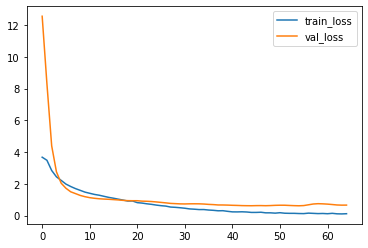

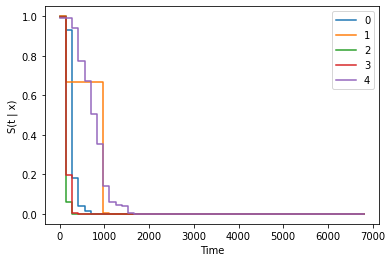

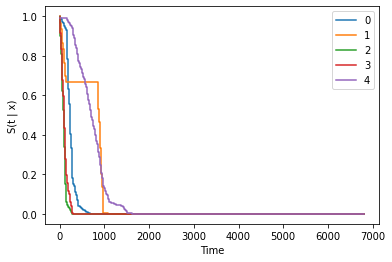

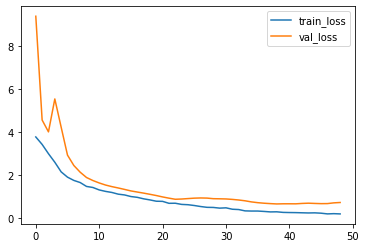

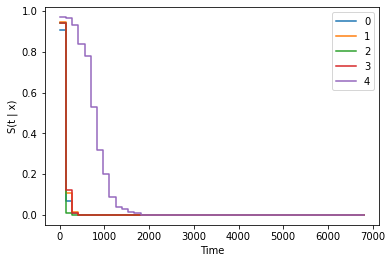

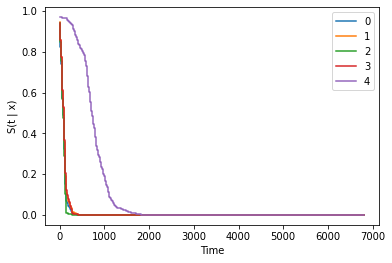

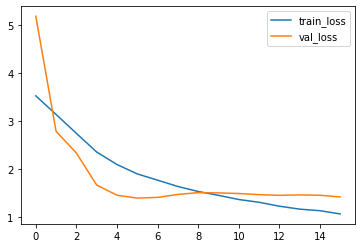

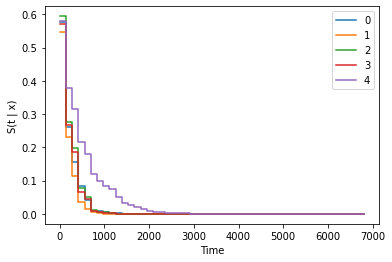

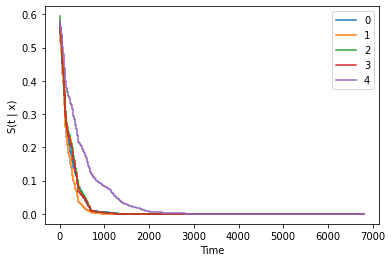

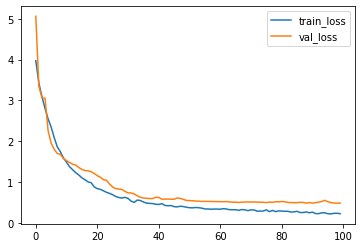

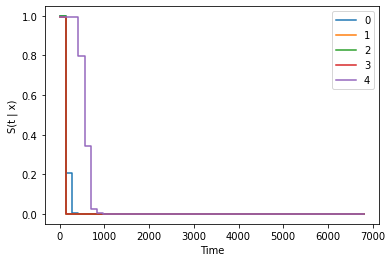

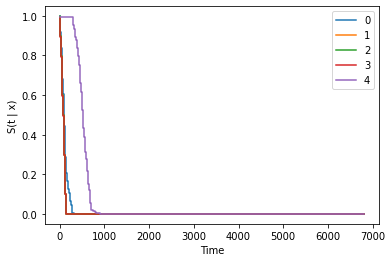

In [5]:
for ct in cancers:
    print(datetime.now(), ct, 'Entered')
    ct_path = f'{path_prefix}{ct}'
    if not os.path.exists(f'{ct}_clinical.pkl'):
        print(datetime.now(), ct, 'skipping because clinical data was not processed')
        continue
    clinical_data = pickle.load(open(f'{ct}_clinical.pkl', 'rb'))
    if not os.path.exists(f'{ct}_omics.pkl'):
        print(datetime.now(), 'Not found', 'merged', f'{ct}_omics.pkl')
    else:
        omics = pickle.load(open(f'{ct}_omics.pkl', 'rb'))
        ci = nn_model(ct, clinical_data, omics, 'merged')
        print(datetime.now(), ct, 'merged', ci)
    if not os.path.exists(f'{ct}_exp_omics.pkl'):
        print(datetime.now(), 'Not found', 'exp', f'{ct}_omics.pkl')
    else:
        exp = pickle.load(open(f'{ct}_exp_omics.pkl', 'rb'))
        ci = nn_model(ct, clinical_data, exp, 'exp')
        print(datetime.now(), ct, 'exp',  ci)
    if not os.path.exists(f'{ct}_methy_omics.pkl'):
        print(datetime.now(), 'Not found', 'methy', f'{ct}_methy_omics.pkl')
    else:
        methy = pickle.load(open(f'{ct}_methy_omics.pkl', 'rb'))
        ci = nn_model(ct, clinical_data, methy, 'methy')
        print(datetime.now(), ct, 'methy',  ci)
    if not os.path.exists(f'{ct}_mirna_omics.pkl'):
        print(datetime.now(), 'Not found', 'mirna', f'{ct}_mirna_omics.pkl')
    else:
        mirna = pickle.load(open(f'{ct}_mirna_omics.pkl', 'rb'))
        ci = nn_model(ct, clinical_data, mirna, 'mirna')
        print(datetime.now(), ct, 'mirna',  ci)
    print()
    print(datetime.now(), ct, 'DONE')
    print()


In [137]:
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (df_train.astype('float32'), y_train)
val = (df_val.astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

in_features = df_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
x_mapper = DataFrameMapper([(col, None) for col in df_train.columns])
x_train = x_mapper.fit_transform(df_train).astype(np.float32)
x_val = x_mapper.fit_transform(df_val).astype(np.float32)
train = (x_train, y_train)
val = (x_val, y_val)

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [ ]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

In [158]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, 
                verbose = True, val_data=val)

0:	[0s / 0s],		train_loss: 30.8273,	val_loss: 10.0848
1:	[0s / 0s],		train_loss: 5.2423,	val_loss: 5.7299
2:	[0s / 0s],		train_loss: 4.7909,	val_loss: 5.0384
3:	[0s / 0s],		train_loss: 4.4108,	val_loss: 4.4345
4:	[0s / 0s],		train_loss: 3.9824,	val_loss: 3.9393
5:	[0s / 0s],		train_loss: 3.6766,	val_loss: 3.3546
6:	[0s / 0s],		train_loss: 3.3523,	val_loss: 2.8163
7:	[0s / 0s],		train_loss: 3.1195,	val_loss: 2.3907
8:	[0s / 0s],		train_loss: 2.7882,	val_loss: 2.0307
9:	[0s / 0s],		train_loss: 2.6395,	val_loss: 1.7476
10:	[0s / 0s],		train_loss: 2.4449,	val_loss: 1.5429
11:	[0s / 0s],		train_loss: 2.2416,	val_loss: 1.4144
12:	[0s / 0s],		train_loss: 2.1816,	val_loss: 1.3273
13:	[0s / 0s],		train_loss: 2.0310,	val_loss: 1.2775
14:	[0s / 0s],		train_loss: 1.9266,	val_loss: 1.2387
15:	[0s / 0s],		train_loss: 1.8465,	val_loss: 1.2089
16:	[0s / 0s],		train_loss: 1.7806,	val_loss: 1.1820
17:	[0s / 0s],		train_loss: 1.6722,	val_loss: 1.1579
18:	[0s / 0s],		train_loss: 1.5990,	val_loss: 1.1335
1

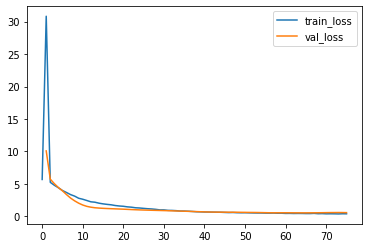

In [159]:
_ = log.plot()

In [160]:
log.to_pandas().val_loss.min()

0.5404947996139526

In [161]:
model.score_in_batches(val)

{'loss': 0.5404947996139526}

In [163]:
x_test = x_mapper.fit_transform(df_test).astype(np.float32)
surv = model.predict_surv_df(x_test)

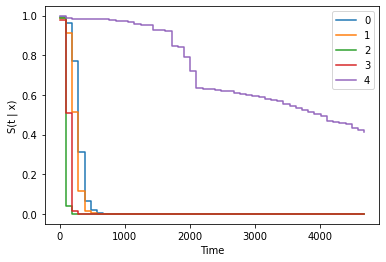

In [164]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [165]:
surv = model.interpolate(10).predict_surv_df(x_test)

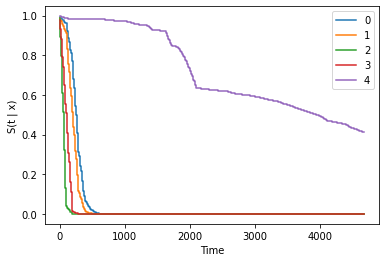

In [166]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [167]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')


In [168]:
ev.concordance_td('antolini')

0.9609375